<a href="https://colab.research.google.com/github/keyvany/decision-making-/blob/main/finalcat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ANNArchy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.7/500.7 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ANNArchy: filename=ANNarchy-4.8.1-cp310-cp310-linux_x86_64.whl size=2051236 sha256=c79b468d98a43a5c29ab175b3d363c799175c6e9193855b0a9a82ec832f91d05
  Stored in directory: /root/.cache/pip/wheels/64/f3/08/809e6acd7efd84e66100ce60777c7a8773f3aead787fa2f967
Successfully built ANNArchy


In [2]:
pip install CompNeuroPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.6/644.6 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 48.1 MB/s eta 0:00:00


In [3]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ANNarchy import (
    Neuron,
    Population,
    Projection,
    Synapse,
    setup,
    compile,
    Uniform,
    simulate,

)
import numpy as np
import random
from CompNeuroPy import CompNeuroMonitors, get_full_model, PlotRecordings


# Setup ANNarchy
setup(dt=1.0, num_threads=1)

# General parameters
ITdimension = 10
baseline_it = random.uniform(0.0, 0.1)
response_threshold = 0.5
nr_fish_presentations = 100



# define the durations of the events
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100

# Set the dopamine condition
max_dopa = 1.0
baseline_dopa = 0.1
baseline_snc = 0.1
min_dopa = 0.0
K_dip = 0.4


# Neuron models
# In Fran's version SaturatedNeuron=LinearNeuron and NormalizationNeuron=LinearNeuron and LinearNeuronPFC=LinearNeuron
LinearNeuron = Neuron(
    parameters="""
        tau = 10.0
        baseline = 0.0
        noise = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = sum(exc) - sum(inh) + baseline + noise*Uniform(-1.0,1.0)
        r = pos(mp)
    """,
)

DopamineNeuron = Neuron(
    parameters="""
        tau = 10.0
        firing = 0
        inhibition = 0.0
        baseline = 0.0
    """,
    equations="""
        ex_in = if (sum(exc)>0): 1 else: 0
        s_inh = sum(inh)
        aux = if (firing>0): (ex_in)*(pos(1.0-baseline-s_inh) + baseline) + (1-ex_in)*(-10*sum(inh)+baseline)  else: baseline
        tau*dmp/dt + mp =  aux
        r = if (mp>0.0): mp else: 0.0
    """,
)

InputNeuron = Neuron(
    parameters="""
        tau = 1.5
        baseline = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = baseline
        baseline_rec = baseline
        r = if (mp>0.0): mp else: 0.0
    """,
)

# Synapse models
# ?? population?
PostCovariance = Synapse(
    parameters="""
        tau = 1000.0
        tau_alpha = 10.0
        regularization_threshold = 1.0
        threshold_post = 0.0
        threshold_pre = 0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha =  pos(post.mp - regularization_threshold)


        trace = (pre.r - mean(pre.r) - threshold_pre) * pos(post.r - mean(post.r) - threshold_post)
    delta = (trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post)*w)
        tau*dw/dt = delta : min=0
   """,
)

ReversedSynapse = Synapse(
    parameters="""
        reversal = 1.0
    """,
    psp="""
        w*pos(reversal-pre.r)
    """,
)

# DA_typ = 1  ==> D1 type  DA_typ = -1 ==> D2 type
DAPostCovarianceNoThreshold = Synapse(
    parameters="""
        tau=1000.0
        tau_alpha=10.0
        regularization_threshold=1.0
        baseline_dopa = 0.1
        K_burst = 1.0
        K_dip = 0.4
        DA_type = 1
        threshold_pre=0.0
        threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha = pos(post.mp - regularization_threshold)
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(post.r -  mean(post.r) - threshold_post) * (pre.r - mean(pre.r) - threshold_pre)

    condition_0 = if (trace>0.0) and (w >0.0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: condition_0*DA_type*K_dip*dopa_sum



        delta = (dopa_mod* trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post))
        tau*dw/dt = delta : min=0
    """,
)

# Excitatory synapses STN -> GPi
DAPreCovariance_excitatory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  = pos( post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (post.r - mean(post.r) - threshold_post)
        aux = if (trace<0.0): 1 else: 0
        dopa_mod = if (dopa_sum>0): K_burst * dopa_sum else: K_dip * dopa_sum * aux
        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0


    """,
)

# Inhibitory synapses GPi -> GPi and STRD2 -> GPe
DAPreCovariance_inhibitory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt = pos( -post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (mean(post.r) - post.r  - threshold_post)
        aux = if (trace>0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: aux*DA_type*K_dip*dopa_sum

        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0
    """,
)

DAPrediction = Synapse(
    parameters="""
        tau = 100000.0
        baseline_dopa = 0.1
   """,
    equations="""
       aux = if (post.sum(exc)>0): 1.0 else: 3.0
       delta = aux*(post.r - baseline_dopa)*pos(pre.r - mean(pre.r))
       tau*dw/dt = delta : min=0
   """,
)


# Populations
# IT Input
IT = Population(name="IT", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
IT.tau = 10.0
IT.baseline = baseline_it

# FEF Input
FEF = Population(name="FEF", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
FEF.tau = 10.0
FEF.baseline = baseline_it

# Lateral SNr
SNr = Population(name="SNr", geometry=2, neuron=LinearNeuron)
SNr.tau = 10.0
SNr.noise = 1.0
SNr.baseline = 0

# Reward Input
Reward_Layer = Population(name="Reward_Layer", geometry=1, neuron=InputNeuron)
Reward_Layer.tau = 1.0

# PFC_MTL
MTL = Population(name="PFC_MTL", geometry=(4, 9), neuron=LinearNeuron)
MTL.tau = 10.0
MTL.noise = 0.05
MTL.baseline = 0.0

# SNc
SNc = Population(name="SNc", geometry=1, neuron=DopamineNeuron)
SNc.tau = 10.0
SNc.firing = 0
SNc.baseline = baseline_snc

# Striatum direct pathway
StrD1 = Population(name="StrD1", geometry=(4, 4), neuron=LinearNeuron)
StrD1.tau = 10.0
StrD1.noise = 0.1
StrD1.baseline = 0.4

# Striatum indirect pathway
StrD2 = Population(name="StrD2", geometry=(4, 4), neuron=LinearNeuron)
StrD2.tau = 10.0
StrD2.noise = 0.1
StrD2.baseline = 0.4

# Striatum feedback pathway
StrThal = Population(name="StrThal-PFC", geometry=2, neuron=LinearNeuron)
StrThal.tau = 10.0
StrThal.noise = 0.1
StrThal.baseline = 0.4

# GPi
GPi = Population(name="GPi-PFC", geometry=2, neuron=LinearNeuron)
GPi.tau = 10.0
GPi.noise = 1.0
GPi.baseline = 2.4

# STN
STN = Population(name="STN", geometry=(4, 4), neuron=LinearNeuron)
STN.tau = 10.0
STN.noise = 0.1
STN.baseline = 0.4

# GPe
GPe = Population(name="GPe", geometry=2, neuron=LinearNeuron)
GPe.tau = 10.0
GPe.noise = 1.0
GPe.baseline = 1.0

# VA
VA = Population(name="VA-PFC", geometry=2, neuron=LinearNeuron)
VA.tau = 10.0
VA.noise = 0.0001
VA.baseline = 0.0

# PM
PM = Population(name="PM", geometry=2, neuron=LinearNeuron)
PM.tau = 10.0
PM.noise = 1.0


# Projections
ITMTL = Projection(pre=IT, post=MTL, target="exc", synapse=PostCovariance)
ITMTL.connect_all_to_all(weights=Uniform(0.2, 0.4))  # Normal(0.3,0.1) )
ITMTL.tau = 15000
ITMTL.regularization_threshold = 3.5
ITMTL.tau_alpha = 1.0
ITMTL.baseline_dopa = baseline_dopa
ITMTL.threshold_post = 0.0
ITMTL.thrshold_pre = 0.15

MTLVA_11 = Projection(pre=MTL[0:8], post=VA[0], target="exc")
MTLVA_11.connect_all_to_all(weights=0.15)
MTLVA_22 = Projection(pre=MTL[8:16], post=VA[1], target="exc")
MTLVA_22.connect_all_to_all(weights=0.15)


IT_StrD1 = Projection(
    pre=IT, post=StrD1, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD1.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD1.tau = 75.0
IT_StrD1.regularization_threshold = 1.0
IT_StrD1.tau_alpha = 1.0
IT_StrD1.baseline_dopa = baseline_dopa
IT_StrD1.K_dip = 0.4
IT_StrD1.K_burst = 1.0
IT_StrD1.DA_type = 1
IT_StrD1.threshold_pre = 0.15

IT_StrD2 = Projection(
    pre=IT, post=StrD2, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD2.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD2.tau = 75.0
IT_StrD2.regularization_threshold = 1.0
IT_StrD2.tau_alpha = 1.0
IT_StrD2.baseline_dopa = baseline_dopa
IT_StrD2.K_dip = 0.4
IT_StrD2.K_burst = 1.0
IT_StrD2.DA_type = -1
IT.threshold_pre = 0.15

IT_STN = Projection(pre=IT, post=STN, target="exc",
                    synapse=DAPostCovarianceNoThreshold)
IT_STN.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_STN.tau = 75.0
IT_STN.regularization_threshold = 1.0
IT_STN.tau_alpha = 1.0
IT_STN.baseline_dopa = baseline_dopa
IT_STN.K_dip = 0.4
IT_STN.K_burst = 1.0
IT_STN.DA_type = 1
IT_STN.threshold_pre = 0.15

Reward_LayerSNc = Projection(pre=Reward_Layer, post=SNc, target="exc")
Reward_LayerSNc.connect_all_to_all(weights=1.0)

VAMTL_11 = Projection(pre=VA[0], post=MTL[0:8], target="exc")
VAMTL_11.connect_all_to_all(weights=0.35)
VAMTL_22 = Projection(pre=VA[1], post=MTL[8:16], target="exc")
VAMTL_22.connect_all_to_all(weights=0.35)

VAPM = Projection(pre=VA, post=PM, target="exc")
VAPM.connect_one_to_one(weights=1.0)

StrD1StrD1 = Projection(pre=StrD1, post=StrD1, target="inh")
StrD1StrD1.connect_all_to_all(weights=0.3)

STNSTN = Projection(pre=STN, post=STN, target="inh")
STNSTN.connect_all_to_all(weights=0.3)

MTLMTL = Projection(pre=MTL, post=MTL, target="inh")
MTLMTL.connect_all_to_all(weights=0.1)

PMPM = Projection(pre=PM, post=PM, target="inh")
PMPM.connect_all_to_all(weights=1.0)

StrD2StrD2 = Projection(pre=StrD2, post=StrD2, target="inh")
StrD2StrD2.connect_all_to_all(weights=0.3)

StrThalStrThal = Projection(pre=StrThal, post=StrThal, target="inh")
StrThalStrThal.connect_all_to_all(weights=0.3)

GPi_GPi = Projection(pre=GPi, post=GPi, target="exc", synapse=ReversedSynapse)
GPi_GPi.connect_all_to_all(weights=1.0)

StrD1_GPi = Projection(
    pre=StrD1, post=GPi, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD1_GPi.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
StrD1_GPi.tau = 50.0
StrD1_GPi.regularization_threshold = 1.0
StrD1_GPi.tau_alpha = 1.0
StrD1_GPi.baseline_dopa = baseline_dopa
StrD1_GPi.K_dip = 0.4
StrD1_GPi.threshold_post = 0.15
StrD1_GPi.DA_type = 1

STN_GPi = Projection(
    pre=STN, post=GPi, target="exc", synapse=DAPreCovariance_excitatory
)
STN_GPi.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
STN_GPi.tau = 50.0
STN_GPi.regularization_threshold = 2.6
STN_GPi.tau_alpha = 1.0
STN_GPi.baseline_dopa = baseline_dopa
STN_GPi.K_dip = 0.4
STN_GPi.thresholdpost = -0.15
STN_GPi.DA_type = 1

StrD2_GPe = Projection(
    pre=StrD2, post=GPe, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD2_GPe.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
StrD2_GPe.tau = 50.0
StrD2_GPe.regularization_threshold = 2.0
StrD2_GPe.tau_alpha = 1.0
StrD2_GPe.baseline_dopa = baseline_dopa
StrD2_GPe.K_dip = 0.4
StrD2_GPe.threshold_post = 0.15
StrD2_GPe.DA_type = -1

StrD1_SNc = Projection(pre=StrD1, post=SNc, target="inh", synapse=DAPrediction)
StrD1_SNc.connect_all_to_all(weights=0.0)
StrD1_SNc.tau = 100000
StrD1_SNc.baseline_dopa = baseline_dopa

GPe_GPi = Projection(pre=GPe, post=GPi, target="inh")
GPe_GPi.connect_one_to_one(weights=1.5)

#FEF_SNr = Projection(pre=FEF, post=SNr, target="inh")
#FEF_SNr.connect_one_to_one(weights=1.5)

#SNr_VA = Projection(pre=SNr, post=VA, target="inh")
#SNr_VA.connect_one_to_one(weights=1.5)


VAStr_Thal = Projection(pre=VA, post=StrThal, target="exc")
VAStr_Thal.connect_one_to_one(weights=1.0)

StrThal_GPe = Projection(pre=StrThal, post=GPe, target="inh")
StrThal_GPe.connect_one_to_one(weights=0.3)

StrThal_GPi = Projection(pre=StrThal, post=GPi, target="inh")
StrThal_GPi.connect_one_to_one(weights=0.3)

GPi_VA = Projection(pre=GPi, post=VA, target="inh")
GPi_VA.connect_one_to_one(weights=0.5)

SNc_StrD1 = Projection(pre=SNc, post=StrD1, target="dopa")
SNc_StrD1.connect_all_to_all(weights=1.0)

SNc_StrD2 = Projection(pre=SNc, post=StrD2, target="dopa")
SNc_StrD2.connect_all_to_all(weights=1.0)

SNc_GPi = Projection(pre=SNc, post=GPi, target="dopa")
SNc_GPi.connect_all_to_all(weights=1.0)

SNc_STN = Projection(pre=SNc, post=STN, target="dopa")
SNc_STN.connect_all_to_all(weights=1.0)

SNc_GPe = Projection(pre=SNc, post=GPe, target="dopa")
SNc_GPe.connect_all_to_all(weights=1.0)

SNc_MTL = Projection(pre=SNc, post=MTL, target="dopa")
SNc_MTL.connect_all_to_all(weights=1.0)

SNc_VA = Projection(pre=SNc, post=VA, target="dopa")
SNc_VA.connect_all_to_all(weights=1.0)

VAPM = Projection(pre=VA, post=PM, target="exc")
VAPM.connect_one_to_one(weights=1.0)

PMIT = Projection(pre=PM, post=IT, target="exc")
PMIT.connect_all_to_all(weights=0.95)


compile()

ANNarchy 4.8 (4.8.1) on linux (posix).
Compiling ...  OK 


In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ANNarchy import (
    Neuron,
    Population,
    Projection,
    Synapse,
    setup,
    compile,
    Uniform,
    simulate,


)
import numpy as np
import random
from CompNeuroPy import CompNeuroMonitors, get_full_model, PlotRecordings


# Setup ANNarchy
setup(dt=1.0, num_threads=1)

# General parameters
ITdimension = 10
baseline_it = random.uniform(0.0, 0.1)
response_threshold = 0.5
nr_fish_presentations = 100

# you have to present multiple times a fish
# --> fish_list contains the fish variants you can present to the model
fish_list = [
    [

    [-1.0,0.0,-1.0,0.0],
     [-1.0,0.0,1.0,1.0],
      [-0.5,0.5,0.0,0.0],
     [-1,0.5,0.0,1],
      [-0.5,-0.5,1.0,0.0],
       [-0.5,-1,0.0,1.0],
            [-1.0, 0.0, -1.0, 0.0],
        [-1.0, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.0, 0.0],
        [-1, 0.5, 0.0, 1],
        [-0.5, -0.5, 1.0, 0.0],
        [-0.5, -1, 0.0, 1.0],
    ],
    [
                 [1.0,0.0,1.0,0.0],
          [0.5,-0.5,0.0,-1.0],
           [1,-0.5,0.0,-1.0],
            [0.5,0.5,1.0,0.0],
             [0.5,1,0.0,1.0],
        [1.0, 0.0, -1.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [0.5, -0.5, 0.0, -1.0],
        [1, -0.5, 0.0, -1.0],
        [0.5, 0.5, 1.0, 0.0],
        [0.5, 1, 0.0, 1.0],
        [1.0,0.0,-1.0,0.0],


    ],
]
feature_name_list = ["DF", "TF", "VF", "MA"]

In [ ]:

ITdimension = 10
baseline_it = random.uniform(0.0, 0.1)
baseline_dopa = 0.9

# Neuron models

LinearNeuron = Neuron(
    parameters="""
        tau = 20.0
        baseline = 0.0
        noise = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = sum(exc) - sum(inh) + baseline + noise*Uniform(-1.0,1.0)
        r = pos(mp)
    """,
)

DopamineNeuron = Neuron(
    parameters="""
        tau = 20.0
        firing = 0
        inhibition = 0.0
        baseline = 0.0
    """,
    equations="""
        ex_in = if (sum(exc)>0): 1 else: 0
        s_inh = sum(inh)
        aux = if (firing>0): (ex_in)*(pos(1.0-baseline-s_inh) + baseline) + (1-ex_in)*(-10*sum(inh)+baseline)  else: baseline
        tau*dmp/dt + mp =  aux
        r = if (mp>0.0): mp else: 0.0
    """,
)

InputNeuron = Neuron(
    parameters="""
        tau = 1.5
        baseline = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = baseline
        baseline_rec = baseline
        r = if (mp>0.0): mp else: 0.0
    """,
)

# In Fran's version SaturatedNeuron=LinearNeuron and NormalizationNeuron=LinearNeuron and LinearNeuronPFC=LinearNeuron

# Synapse models
# ?? population?
PostCovariance = Synapse(
    parameters="""
        tau = 1000.0
        tau_alpha = 10.0
        regularization_threshold = 1.0
        threshold_post = 0.0
        threshold_pre = 0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha =  pos(post.mp - regularization_threshold)


        trace = (pre.r - mean(pre.r) - threshold_pre) * pos(post.r - mean(post.r) - threshold_post)
    delta = (trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post)*w)
        tau*dw/dt = delta : min=0
   """,
)

ReversedSynapse = Synapse(
    parameters="""
        reversal = 1.0
    """,
    psp="""
        w*pos(reversal-pre.r)
    """,
)

# DA_typ = 1  ==> D1 type  DA_typ = -1 ==> D2 type
DAPostCovarianceNoThreshold = Synapse(
    parameters="""
        tau=1000.0
        tau_alpha=10.0
        regularization_threshold=1.0
        baseline_dopa = 0.1
        K_burst = 1.0
        K_dip = 0.4
        DA_type = 1
        threshold_pre=0.0
        threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha = pos(post.mp - regularization_threshold)
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(post.r -  mean(post.r) - threshold_post) * (pre.r - mean(pre.r) - threshold_pre)

    condition_0 = if (trace>0.0) and (w >0.0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: condition_0*DA_type*K_dip*dopa_sum



        delta = (dopa_mod* trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post))
        tau*dw/dt = delta : min=0
    """,
)

# Excitatory synapses STN -> GPi
DAPreCovariance_excitatory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  = pos( post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (post.r - mean(post.r) - threshold_post)
        aux = if (trace<0.0): 1 else: 0
        dopa_mod = if (dopa_sum>0): K_burst * dopa_sum else: K_dip * dopa_sum * aux
        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0


    """,
)


# Inhibitory synapses GPi -> GPi and STRD2 -> GPe
DAPreCovariance_inhibitory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt = pos( -post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (mean(post.r) - post.r  - threshold_post)
        aux = if (trace>0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: aux*DA_type*K_dip*dopa_sum

        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0
    """,
)


DAPrediction = Synapse(
    parameters="""
        tau = 100000.0
        baseline_dopa = 0.1
   """,
    equations="""
       aux = if (post.sum(exc)>0): 1.0 else: 3.0
       delta = aux*(post.r - baseline_dopa)*pos(pre.r - mean(pre.r))
       tau*dw/dt = delta : min=0
   """,
)

setup(dt=1.0, num_threads=1)

# Set the dopamine condition
# Control

max_dopa = 1.5
baseline_dopa = 0.1
min_dopa = 0.0
K_dip = 0.5


# TraceSynapse = default annarchy synapse


# Creation of the neurons



# IT Input
IT = Population(name='IT', geometry=(ITdimension,ITdimension), neuron=InputNeuron)
IT.tau = 100.0
IT.baseline = baseline_it

# Reward Input
Reward_Layer = Population(name="Reward_Layer", geometry=1, neuron=InputNeuron)
Reward_Layer.tau = 1.0

# PFC
PFC = Population(name="PFC", geometry=16, neuron=LinearNeuron)
PFC.tau = 10.0
PFC.noise = 0.05
PFC.baselie = 0.0

# SNc
SNc = Population(name="SNc",geometry=1,neuron=DopamineNeuron)
SNc.tau = 10.0
SNc.firing = 0
SNc.baseline = 0.1

# Striatum direct pathway
StrD1 = Population(name="StrD1", geometry=(4,4),neuron = LinearNeuron)
StrD1.tau = 10.0
StrD1.noise = 0.1
StrD1.baseline = 0.4

# Striatum indirect pathway
StrD2 = Population(name="StrD2", geometry = (4,4), neuron=LinearNeuron)
StrD2.tau = 10.0
StrD2.noise = 0.1
StrD2.baseline = 0.4

# Striatum feedback pathway
StrThal = Population(name="StrThal-PFC", geometry = 2, neuron=LinearNeuron)
StrThal.tau = 10.0
StrThal.noise = 0.1
StrThal.baseline = 0.4

# SNr
SNrGPi = Population(name="SNr-GPi", geometry =2, neuron=LinearNeuron)
SNrGPi.tau = 10.0
SNrGPi.noise = 0.1
SNrGPi.baseline = 0.4

# STN
STN = Population(name="STN", geometry = (4,4), neuron=LinearNeuron)
STN.tau = 10.0
STN.noise = 0.1
STN.baseline = 0.4

# GPe
GPe = Population(name="GPe", geometry = 2, neuron=LinearNeuron)
GPe.tau = 10.0
GPe.noise = 0.0
GPe.baseline = 1.0

# VA
VA = Population(name="VA-PFC", geometry=2, neuron=LinearNeuron)
VA.tau = 10.0
VA.noise = 0.0001
VA.baseline = 0.0

# PM
PM = Population(name="PM", geometry = 2, neuron=LinearNeuron)
PM.tau = 10.0
PM.noise = 1.0
PM.noise=0.0
#Projections

ITPFC = Projection(pre=IT,post=PFC,target="exc",synapse=PostCovariance)
ITPFC.connect_all_to_all( weights = Uniform(0.2,0.4)) #Normal(0.3,0.1) )
ITPFC.tau = 15000
ITPFC.regularization_threshold = 3.5
ITPFC.tau_alpha = 1.0
ITPFC.baseline_dopa = baseline_dopa
ITPFC.threshold_post = 0.0
ITPFC.thrshold_pre = 0.15

PFCVA_11 = Projection(pre=PFC[0:8],post=VA[0],target="exc")
PFCVA_11.connect_all_to_all(weights = 0.15)
PFCVA_22 = Projection(pre=PFC[8:16],post=VA[1],target="exc")
PFCVA_22.connect_all_to_all(weights = 0.15)


ITStrD1 = Projection(pre=IT,post=StrD1,target='exc',synapse=DAPostCovarianceNoThreshold)
ITStrD1.connect_all_to_all(weights = Uniform(0,0.3)) #Normal(0.15,0.15))
ITStrD1.tau = 75.0
ITStrD1.regularization_threshold = 1.0
ITStrD1.tau_alpha = 1.0
ITStrD1.baseline_dopa = baseline_dopa
ITStrD1.K_dip = 0.4
ITStrD1.K_burst = 1.0
ITStrD1.DA_type = 1
ITStrD1.threshold_pre = 0.15

ITStrD2 = Projection(pre=IT,post=StrD2,target='exc',synapse=DAPostCovarianceNoThreshold)
ITStrD2.connect_all_to_all(weights = Uniform(0,0.3)) #Normal(0.15,0.15))
ITStrD2.tau = 75.0
ITStrD2.regularization_threshold = 1.0
ITStrD2.tau_alpha = 1.0
ITStrD2.baseline_dopa = baseline_dopa
ITStrD2.K_dip = 0.4
ITStrD2.K_burst = 1.0
ITStrD2.DA_type = -1
IT.threshold_pre = 0.15

ITSTN = Projection(pre=IT, post=STN, target='exc',synapse=DAPostCovarianceNoThreshold)
ITSTN.connect_all_to_all(weights = Uniform(0,0.3)) #Normal(0.15,0.15))
ITSTN.tau = 75.0
ITSTN.regularization_threshold = 1.0
ITSTN.tau_alpha = 1.0
ITSTN.baseline_dopa = baseline_dopa
ITSTN.K_dip = 0.4
ITSTN.K_burst = 1.0
ITSTN.DA_type = 1
ITSTN.threshold_pre = 0.15

SNcStrD1 = Projection(pre=SNc,post=StrD1,target='dopa')
SNcStrD1.connect_all_to_all(weights = 1.0)

SNcStrD2 = Projection(pre=SNc,post=StrD2,target='dopa')
SNcStrD2.connect_all_to_all(weights = 1.0)

Reward_LayerSNc = Projection(pre=Reward_Layer,post=SNc,target='exc')
Reward_LayerSNc.connect_all_to_all(weights=1.0)

SNcSTN = Projection(pre=SNc,post=STN,target='dopa')
SNcSTN.connect_all_to_all(weights = 1.0)

VAPFC_11 = Projection(pre=VA[0],post=PFC[0:8],target='exc')
VAPFC_11.connect_all_to_all(weights=0.35)
VAPFC_22 = Projection(pre=VA[1],post=PFC[8:16],target='exc')
VAPFC_22.connect_all_to_all(weights=0.35)

VAPM = Projection(pre=VA,post=PM,target='exc')
VAPM.connect_one_to_one(weights=1.5)

StrD1StrD1 = Projection(pre=StrD1,post=StrD1,target='inh')
StrD1StrD1.connect_all_to_all(weights = 0.3)

STNSTN = Projection(pre=STN,post=STN,target='inh')
STNSTN.connect_all_to_all(weights = 0.3)

PFCPFC = Projection(pre=PFC,post = PFC,target='inh')
PFCPFC.connect_all_to_all(weights = 0.3)

PMPM = Projection(pre=PM,post=PM,target='inh')
PMPM.connect_all_to_all(weights = 0.3)

StrD2StrD2 = Projection(pre=StrD2,post=StrD2,target='inh')
StrD2StrD2.connect_all_to_all(weights=0.3)

StrThalStrThal = Projection(pre=StrThal,post=StrThal,target='inh')
StrThalStrThal.connect_all_to_all(weights=0.3)

SNrGPiSNrGPi = Projection(pre=SNrGPi,post=SNrGPi,target='exc',synapse=ReversedSynapse)
SNrGPiSNrGPi.connect_all_to_all(weights=1.0)

StrD1SNrGPi = Projection(pre=StrD1,post=SNrGPi,target='inh',synapse=DAPreCovariance_inhibitory)
StrD1SNrGPi.connect_all_to_all(weights=Uniform(0,0.05)) #Normal(0.025,0.025))
StrD1SNrGPi.tau = 50.0
StrD1SNrGPi.regularization_threshold = 1.0
StrD1SNrGPi.tau_alpha = 1.0
StrD1SNrGPi.baseline_dopa = baseline_dopa
StrD1SNrGPi.K_dip = 0.4
StrD1SNrGPi.threshold_post = 0.15
StrD1SNrGPi.DA_type=1

STNSNrGPi = Projection(pre=STN,post=SNrGPi,target='exc',synapse=DAPreCovariance_excitatory)
STNSNrGPi.connect_all_to_all(weights=Uniform(0,0.05)) #Normal(0.025,0.025))
STNSNrGPi.tau = 50.0
STNSNrGPi.regularization_threshold = 2.6
STNSNrGPi.tau_alpha = 1.0
STNSNrGPi.baseline_dopa = baseline_dopa
STNSNrGPi.K_dip = 0.4
STNSNrGPi.thresholdpost =-0.15
STNSNrGPi.DA_type = 1

StrD2GPe = Projection(pre=StrD2,post=GPe,target='inh',synapse=DAPreCovariance_inhibitory)
StrD2GPe.connect_all_to_all(weights=Uniform(0,0.05)) #Normal(0.025,0.025))
StrD2GPe.tau = 50.0
StrD2GPe.regularization_threshold = 2.0
StrD2GPe.tau_alpha = 1.0
StrD2GPe.baseline_dopa = baseline_dopa
StrD2GPe.K_dip = 0.4
StrD2GPe.threshold_post = 0.15
StrD2GPe.DA_type = -1

StrD1SNc = Projection(pre=StrD1,post=SNc,target='inh',synapse=DAPrediction)
StrD1SNc.connect_all_to_all(weights=0.0)
StrD1SNc.tau = 100000
StrD1SNc.baseline_dopa = 0.1

GPeSNrGPi = Projection(pre=GPe,post=SNrGPi,target='inh')
GPeSNrGPi.connect_one_to_one(weights=1.5)

VAStrThal = Projection(pre=VA,post=StrThal,target='exc')
VAStrThal.connect_one_to_one(weights=1.0)

StrThalGPe = Projection(pre=StrThal,post=GPe,target='inh')
StrThalGPe.connect_one_to_one(weights=0.3)

StrThalSNrGPi = Projection(pre=StrThal,post=SNrGPi,target='inh')
StrThalSNrGPi.connect_one_to_one(weights=0.3)

SNrGPiVA = Projection(pre=SNrGPi,post=VA,target='inh')
SNrGPiVA.connect_one_to_one(weights=0.5)

SNcStrD1 = Projection(pre=SNc,post=StrD1,target='dopa')
SNcStrD1.connect_all_to_all(weights = 1.0)

SNcStrD2 = Projection(pre=SNc,post=StrD2,target='dopa')
SNcStrD2.connect_all_to_all(weights = 1.0)

SNcSNrGPi= Projection(pre=SNc,post=SNrGPi,target='dopa')
SNcSNrGPi.connect_all_to_all(weights = 1.0)

SNcSTN = Projection(pre=SNc,post=STN,target='dopa')
SNcSTN.connect_all_to_all(weights = 1.0)

SNcGPe = Projection(pre=SNc,post=GPe,target='dopa')
SNcGPe.connect_all_to_all(weights = 1.0)

SNcPFC = Projection(pre=SNc,post=PFC,target='dopa')
SNcPFC.connect_all_to_all(weights = 1.0)

SNcVA = Projection(pre=SNc,post=VA,target='dopa')
SNcVA.connect_all_to_all(weights = 1.0)

# m_it_d1 = Monitor(ITStrD1,'w')
# m_it_d2 = Monitor(IT_StrD2,'w')
# m_it_pfc = Monitor(ITPFC,'w')


# m_mtl = Monitor(MTL, "r")
# m_str = Monitor(StrD1, "r")

compile()



weights = np.zeros((65, 16, 100))
inputs = np.zeros((65, 10, 10))
dopas = np.zeros((65, 16))
weights_snr = np.zeros((65, 2, 16))
weights_stn = np.zeros((65, 2, 16))
weights_it_stn = np.zeros((65, 16, 100))

Compiling ...  OK 


In [8]:
populations = get_full_model()["populations"]
print(populations)
kol=[]
poplist=[pop for pop in populations]
print(poplist)
mon_dict={""+pop:["r"] for pop in populations}

['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi-PFC', 'STN', 'GPe', 'VA-PFC', 'PM']
['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi-PFC', 'STN', 'GPe', 'VA-PFC', 'PM']


In [6]:
mon_dict={"IT":["r"],"Reward_Layer":["r"],"PFC":["r"],"SNc":["r"],"StrD1":["r"],"StrD2":["r"],"StrThal-PFC":["r"],"SNr-GPi":["r"],"STN":["r"],"GPe":["r"],"VA-PFC":["r"],"PM":["r"]}

In [9]:

mon=CompNeuroMonitors(mon_dict)

In [10]:
populations = get_full_model()["populations"]
#mon_dict={"IT":["r"]}
#mon_dict = {""+pop: ["r"] for pop in populations}
print(populations)
print(mon_dict)
#mon_dict["IT"] = ["r"]
#mon = Monitors(mon_dict)
# mon1=Monitors(["IT"])
mon = CompNeuroMonitors(mon_dict)
print(mon.get_recording_times)

['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi-PFC', 'STN', 'GPe', 'VA-PFC', 'PM']
{'IT': ['r'], 'FEF': ['r'], 'SNr': ['r'], 'Reward_Layer': ['r'], 'PFC_MTL': ['r'], 'SNc': ['r'], 'StrD1': ['r'], 'StrD2': ['r'], 'StrThal-PFC': ['r'], 'GPi-PFC': ['r'], 'STN': ['r'], 'GPe': ['r'], 'VA-PFC': ['r'], 'PM': ['r']}
<bound method CompNeuroMonitors.get_recording_times of <CompNeuroPy.monitors.CompNeuroMonitors object at 0x7b698c10a200>>


In [11]:
def get_fish(fish_list, feature_name_list):
    """
    return a dictionary with features and feature values

    Args:
        fish_list: list
            list with all possible fishes consisting of 4 feature values
        feature_name_list: list
            list containing 4 strings, the names of the 4 features (the order corresponds to the order in fish_list)
    """
    input_1 = random.randint(0, 1)
    # print(input_1)
    input_11 = random.randint(
        0, 5
    )
    input_sacc = fish_list[input_1][input_11]
    # print(input_sacc)
    fish = dict(zip(feature_name_list, input_sacc))
    return fish

In [12]:
def get_true_category(fish):
    important_feature =  "DF"
    important_feature1= "VF"
    """
    returns the of a given fish based on a single feature
    """
    if fish[important_feature] == 1 or fish[important_feature] == 0.5:
        cat = "B"
    elif fish[important_feature1] == 1 or fish[important_feature1] == 0.5:
        cat = "B"

    if fish[important_feature] == -1 or fish[important_feature] == -0.5:
        cat = "A"
    elif fish[important_feature1] == -1 or fish[important_feature1] == -0.5:
        cat = "A"
    return cat

In [13]:
def select_input(feature_name, fish, IT, feature_name_list, baseline_default):
    """
    activates IT neurons based on the presented feature

    Args:
        feature_name: string
            name of the activated feature
        fish: dictionary
            dictionary containing the feature values for the fish features
        IT: ANNarchy population
            the IT population
        feature_name_list: list
            list containing 4 strings, the names of the 4 features (the order corresponds to the order in fish_list)
        baseline_default: float
            default baseline of IT
    """
    # set deafult baseline
    IT.baseline = baseline_default

    # feature name i.e. spatial position defines the group of IT neurons
    nr_IT_neurons = len(IT)
    nr_group_neurons = nr_IT_neurons // (len(feature_name_list))
    neuron_group_idx = feature_name_list.index(feature_name)
    neuron_group = IT[
        int(neuron_group_idx * nr_group_neurons): int(
            (neuron_group_idx + 1) * nr_group_neurons
        )
    ]

    # feature value defines which neurons of neuron group get active --> neuron groups are feature-value selective
    feature_value = fish[feature_name]
    activity_center_idx = ((feature_value - (-1)) /
                           (1 - (-1))) * (nr_group_neurons - 1)

    activity = gauss_1D(
        m=activity_center_idx,
        sig=nr_group_neurons / 10,
        size=nr_group_neurons,
        min=neuron_group.baseline[0],
    )

    # set the activity of the neuron group
    neuron_group.baseline = activity

In [14]:
def gauss_1D(m, sig, size, min):
    """
    returns a 1D gaussian array

    Args:
        m: float
            center/mean of the gaussian along the array indizes
        sig: float
            standard deviation in array indizes
        size: int
            size of the returned array
        min: float
            minimum value
    """
    return np.clip(np.exp(-((np.arange(size) - m) ** 2) / (2 * sig**2)), min, None)


def get_feature_order(feature_name_list):
    """
    return a list with feature names containing the presentation order of the fish features
    """
    idx_arr = np.arange(len(feature_name_list))
    feature_name_arr = np.array(feature_name_list)
    np.random.shuffle(idx_arr)
    return feature_name_arr[idx_arr].tolist()

In [ ]:
fish_list = [
    [

    [-1.0,0.0,-1.0,0.0],
     [-1.0,0.0,1.0,1.0],
      [-0.5,0.5,0.0,0.0],
     [-1,0.5,0.0,1],
      [-0.5,-0.5,1.0,0.0],
       [-0.5,-1,0.0,1.0],
            [-1.0, 0.0, -1.0, 0.0],
        [-1.0, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.0, 0.0],
        [-1, 0.5, 0.0, 1],
        [-0.5, -0.5, 1.0, 0.0],
        [-0.5, -1, 0.0, 1.0],
    ],
    [
                 [1.0,0.0,1.0,0.0],
          [0.5,-0.5,0.0,-1.0],
           [1,-0.5,0.0,-1.0],
            [0.5,0.5,1.0,0.0],
             [0.5,1,0.0,1.0],
        [1.0, 0.0, -1.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [0.5, -0.5, 0.0, -1.0],
        [1, -0.5, 0.0, -1.0],
        [0.5, 0.5, 1.0, 0.0],
        [0.5, 1, 0.0, 1.0],
        [1.0,0.0,-1.0,0.0],


    ],
]
feature_name_list = ["DF", "TF", "VF", "MA"]

In [16]:

from collections import deque
import numpy as np
performance_percent_list=[]
avg_performance_window=0
average_performance = 0
consecutive_correct = 0
trial_correctness_list = []
performance_percent = 0
mylist = []
perpi = []
all_performance_values=[]
performance_values=[]
average_performance_list=[]
performance_percent_list = []
response_threshold = 3.99
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100
nr_fish_presentations = 100
correct_trials = 0  # Initialize the count of correct trials
rolling_window = deque(maxlen=10)  # Define a deque with a maximum length of 10 for the rolling window
baseline_it=0.1
for fing in range(nr_fish_presentations):
    mon.reset()
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)
    mon.reset()
    if avg_performance_window>0.62:
        break
    for feature_name in feature_order:
        mon.start()
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)
        simulate(trial_duration)

        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)

        if response_value > response_threshold or feature_name == feature_order[-1]:
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            category_selected = ["A", "B"][response_idx]
           # print(f"{fing}th fish is:\n{fish}")
            #print(response_idx+1,response_value)

            if category_selected == category_true:
                Reward_Layer.baseline = 1
                SNc.firing = 1
                consecutive_correct += 1
                correct_trials += 1
                mylist.append(1)
            else:
                Reward_Layer.baseline = 0
                SNc.firing = 0
                consecutive_correct = 0
                SNc.firing = 0
                mylist.append(0)
           # if fing>5:
              #  performance_percent = (consecutive_correct / (fing )) * 100
               # rolling_window.append(performance_percent)
           # print(performance_percent)
          #  if fing>=50:
                #avg_performance_window = sum(mylist) / 50
               # performance_percent_list.append(avg_performance_window)
                #print(avg_performance_window,response_value)
            trial_performance = 1 if category_selected == category_true else 0
            performance_values.append(trial_performance)

            rolling_window.append(trial_performance)

            if len(rolling_window) == 10:
               avg_performance = sum(rolling_window) / 10
               print(avg_performance)
               average_performance_list.append(avg_performance)
               b=np.std(average_performance_list)
            simulate(dopamine_input_duration)
            simulate(calcium_trace_decline_duration)

            mon.pause()
            break
            mon.reset()

0.4
0.3
0.3
0.3
0.4
0.5
0.4
0.4
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.6
0.7
0.6
0.6
0.5
0.6
0.6
0.5
0.4
0.3
0.2
0.2
0.3
0.4
0.5
0.4
0.5
0.6
0.6
0.7
0.7
0.6
0.5
0.4
0.3
0.3
0.2
0.2
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.4
0.4
0.3
0.2
0.2
0.2
0.2
0.3
0.3
0.3
0.3
0.4
0.4
0.4
0.4
0.5
0.6
0.5
0.5
0.5
0.4
0.4
0.5
0.5
0.4
0.3
0.2
0.3
0.4
0.5
0.6
0.6
0.5
0.5
0.6
0.6
0.6
0.6
0.5
0.5


In [17]:
#all_performance_values=[]
khar=[]
#goh=[]
#khar.append(b)
all_performance_values.append(average_performance_list)
print(len(all_performance_values))
print(all_performance_values)
c=0

1
[[0.4, 0.3, 0.3, 0.3, 0.4, 0.5, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.6, 0.6, 0.5, 0.6, 0.6, 0.5, 0.4, 0.3, 0.2, 0.2, 0.3, 0.4, 0.5, 0.4, 0.5, 0.6, 0.6, 0.7, 0.7, 0.6, 0.5, 0.4, 0.3, 0.3, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.5, 0.5, 0.5, 0.4, 0.4, 0.5, 0.5, 0.4, 0.3, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5]]


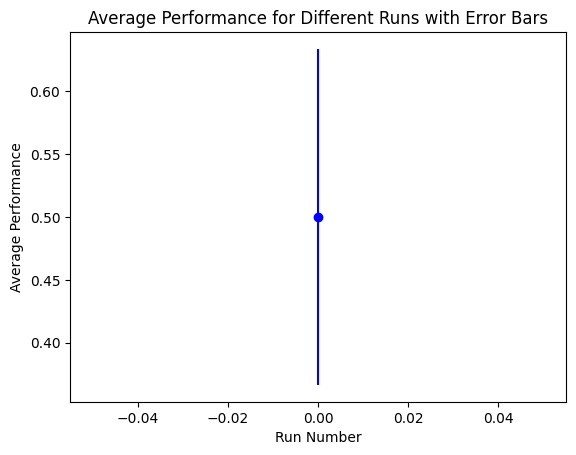

1
[0.4, 0.3, 0.3, 0.3, 0.4, 0.5, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.6, 0.6, 0.5, 0.6, 0.6, 0.5, 0.4, 0.3, 0.2, 0.2, 0.3, 0.4, 0.5, 0.4, 0.5, 0.6, 0.6, 0.7, 0.7, 0.6, 0.5, 0.4, 0.3, 0.3, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.5, 0.5, 0.5, 0.4, 0.4, 0.5, 0.5, 0.4, 0.3, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5]


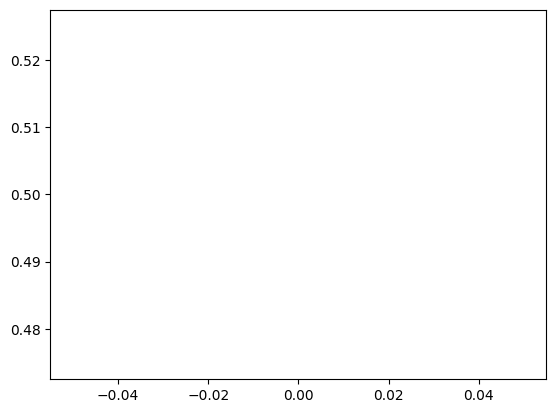

In [20]:
std_deviation_list=[]
goh=[]
for performance_values in all_performance_values:
    c=sum(performance_values[-10:]) / len(performance_values[-10:])
    goh.append(performance_values[-1])
    std_deviation = [np.std(performance_values)]
    std_deviation_list.append(std_deviation)
    import numpy as np
datapoints=range(0,10*len(goh),10 )
plt.errorbar(datapoints, goh, yerr=std_deviation, fmt='-o', color='blue')
plt.xlabel('Run Number')
plt.ylabel('Average Performance')
plt.title('Average Performance for Different Runs with Error Bars')
plt.show()
plt.plot(goh)
print(len(goh))
print(performance_values)

In [ ]:
print(len(mylist))
ka=[]

100


In [ ]:
kol.append(performance_percent_list[-1])

ka.append(performance_percent_list)

IndexError: list index out of range

[]


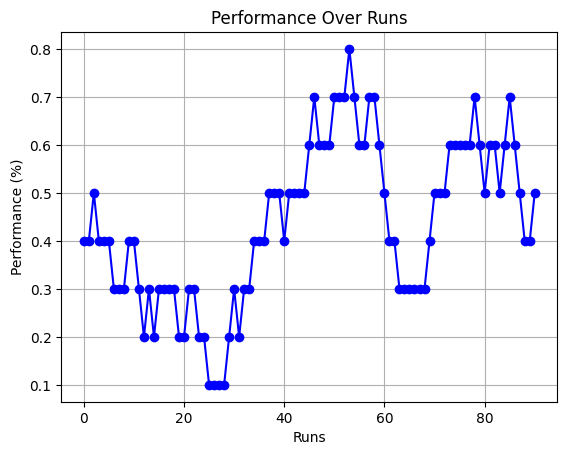

In [ ]:
print(kol)
b=[0.54, 0.54, 0.55, 0.59, 0.6, 0.62, 0.64, 0.64, 0.66, 0.68, 0.68, 0.7, 0.7, 0.72, 0.75, 0.76, 0.79, 0.79, 0.8, 0.81, 0.82, 0.84, 0.84, 0.84, 0.87, 0.88, 0.9, 0.91, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 0.98, 1.0, 1.0, 1.0]

#perpi.reverse()
import matplotlib.pyplot as plt


plt.figure()
plt.plot(average_performance_list,'-o',color='b')
plt.xlabel('Runs')
plt.ylabel('Performance (%)')
plt.title('Performance Over Runs')

plt.grid()
plt.show()

[0.54, 0.54, 0.56, 0.56, 0.56, 0.56, 0.58, 0.58, 0.6, 0.62, 0.64, 0.64, 0.64, 0.64, 0.66, 0.66, 0.68, 0.7, 0.72, 0.74, 0.74, 0.76, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.86, 0.86, 0.86, 0.86, 0.88, 0.88, 0.88, 0.88, 0.9, 0.92, 0.94, 0.94, 0.94, 0.96, 0.98, 0.98, 1.0]
[0.44, 0.46, 0.46, 0.48, 0.48, 0.48, 0.48, 0.5, 0.52, 0.54, 0.56, 0.56, 0.56, 0.58, 0.58, 0.6, 0.62, 0.62, 0.64, 0.66, 0.66, 0.68, 0.7, 0.7, 0.72, 0.72, 0.74, 0.74, 0.76, 0.78, 0.78, 0.78, 0.8, 0.8, 0.82, 0.82, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.86, 0.88, 0.9, 0.9, 0.9]


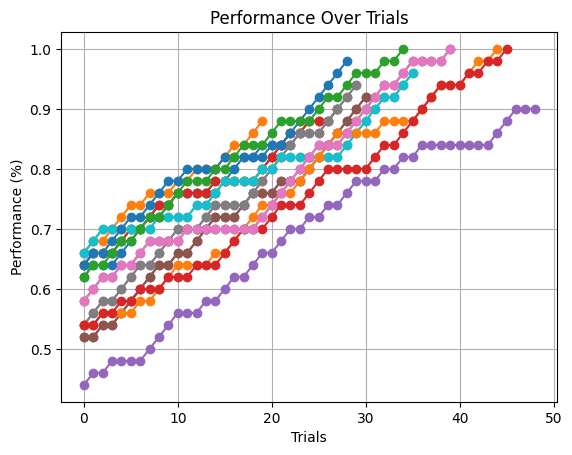

In [ ]:
print(ka[11])
print(ka[14])
ja=[np.mean(ka[k][0:40]) for k in range(len(ka))]
plt.figure
for i in range(len(ka)):

    plt.plot(ka[i],'-o')

    plt.xlabel('Trials')
    plt.ylabel('Performance (%)')
    plt.title('Performance Over Trials')
plt.grid()
plt.show()

0.6
0.5
0.4
0.4
0.5
0.6
0.6
0.6
0.7
0.6
0.7
0.8
0.8
0.8
0.7
0.6
0.5
0.4
0.3
0.4
0.4
0.3
0.4
0.3
0.4
0.4
0.5
0.5
0.6
0.5
0.4
0.5
0.4
0.4
0.3
0.3
0.3
0.4
0.3
0.3


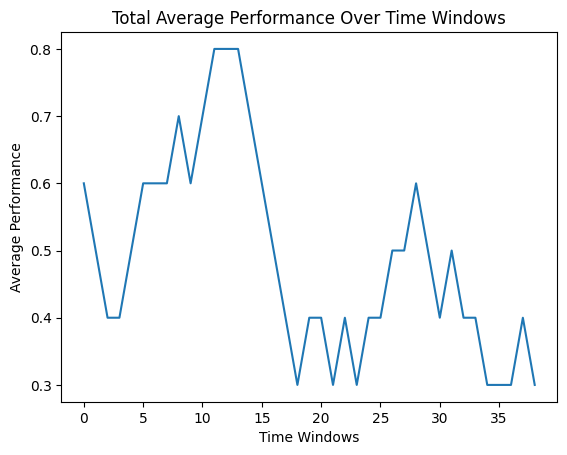

In [ ]:

import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random

# Your existing custom code...
average_performance_list = []
std_deviation_list = []

baseline_it = random.uniform(0.0, 0.1)
b= 0
mylist = []
average_performance = 0
consecutive_correct = 0
trial_correctness_list = []
performance_percent = 0
perpi = []
performance_percent_list = []
response_threshold = 0.01
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100
nr_fish_presentations = 50
correct_trials = 0
rolling_window = deque(maxlen=10)
#aav=[]
# List to store performance values for each trial
performance_values = []

for fing in range(1, nr_fish_presentations, 1):
    # Your existing code for fish presentation...
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)
    response_value=0
    mon.reset()
    for feature_name in feature_order:

        mon.start()
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)
        simulate(trial_duration)
        simulate(dopamine_input_duration)
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)
        #print(response_value)
        if response_value > response_threshold or feature_name == feature_order[-1]:
            baseline_it=0.0
            #IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            category_selected = ["A", "B"][response_idx]
           # print(f"{fing}th fish is:\n{fish}")


            if category_selected == category_true:
                Reward_Layer.baseline = 1

                consecutive_correct += 1
                correct_trials += 1
                mylist.append(1)
                #trial_performance = 1 if category_selected == category_true else 0
               # performance_values.append(trial_performance)

            else:
                Reward_Layer.baseline = 0

                mylist.append(0)
               # consecutive_correct = 0

            simulate(dopamine_input_duration)
            SNc.firing = 1


            # Reward_Layer.baseline = 0
            SNc.firing = 0

    # Simulate fish and responses...

    trial_performance = 1 if category_selected == category_true else 0
    performance_values.append(trial_performance)

    rolling_window.append(trial_performance)

    if len(rolling_window) == 10:
        avg_performance = sum(rolling_window) / 10
        print(avg_performance)
        average_performance_list.append(avg_performance)
        b=np.std(average_performance_list)

        if avg_performance>0.80: break
    mon.pause()
    #break
    mon.reset()       # if sum(rolling_window)==9: break

     #   if sum(performance_values[len(performance_values)-10:len(performance_values)]) / 10>0.70 :
         #b=sum(performance_values[len(performance_values)-10:len(performance_values)])/10
           #print(b)
         #  break
         # print(f'Average performance for time window [{fing - 9}:{fing + 1}]: {avg_performance}')
       # print(sum(rolling_window))

# Plotting the total average performance
plt.plot(range(len(performance_values)-10), [sum(performance_values[i:i+10]) / 10 for i in range(len(performance_values)-10)])
plt.xlabel('Time Windows')
plt.ylabel('Average Performance')
plt.title('Total Average Performance Over Time Windows')
plt.show()

[[0.62 0.64 0.64 0.64 0.66 0.68 0.7  0.72 0.72 0.74 0.76 0.76 0.76 0.76
  0.76 0.78 0.8  0.82 0.82 0.82 0.84 0.84 0.84 0.86 1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.  ]
 [0.66 0.68 0.68 0.7  0.72 0.74 0.74 0.76 0.76 0.76 0.78 0.78 0.8  0.8
  0.8  0.82 0.84 0.84 0.86 0.88 1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.  ]
 [0.64 0.66 0.66 0.66 0.68 0.7  0.7  0.72 0.74 0.74 0.76 0.76 0.76 0.76
  0.78 0.78 0.78 0.78 0.78 0.8  0.82 0.84 0.86 0.86 0.88 0.88 0.88 0.9
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.  ]
 [0.64 0.66 0.66 0.66 0.68 0.7  0.7  0.72 0.74 0.74 0.76 0.76 0.76 0.76
  0.78 0.78 0.78 0.78 0.78 0.8  0.82 0.84 0.86 0.86 0.88 0.88 0.88 0.9
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.  ]

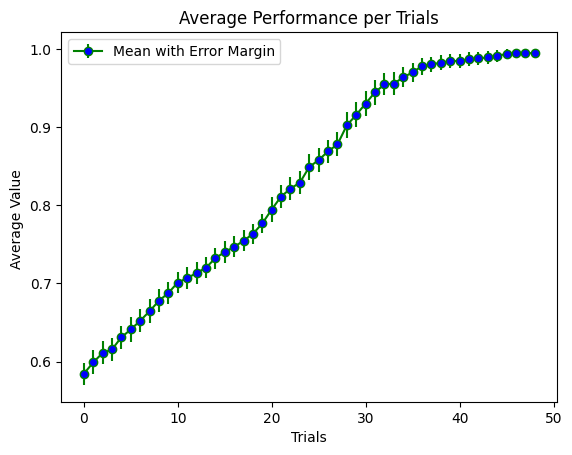

In [ ]:

data = ka



# Attempt to create a NumPy array from the list of lists
#arr = np.array(data)

# This will raise the error: setting an array element with a sequence.
# The requested array has an inhomogeneous shape after 1 dimensions.
# The detected shape was (3,) + inhomogeneous part.

# To resolve this issue, you can pad the lists with a consistent value (e.g., NaN) to make them of equal length
max_len = max(len(sublist) for sublist in data)
data_padded = [sublist + [1]*(max_len-len(sublist)) for sublist in data]

# Create a NumPy array from the padded list of lists
arr = np.array(data_padded)

print(arr)
# Calculate mean and standard error for each point
data=arr


data = arr
means = np.mean(data, axis=0)
errors = np.std(data, axis=0) / np.sqrt(len(data))

# Plotting the data as scatter plot with error bars
plt.errorbar(range(len(means)), means, yerr=errors, fmt='-o', color='green', label='Mean with Error Margin', markerfacecolor='blue')
plt.xlabel('Trials')
plt.ylabel('Average Value ')
plt.title('Average Performance per Trials')
#plt.xticks(range(len(means)), range(49))
plt.legend()
plt.show()

In [ ]:
m = 0
l=0
sa=[]
for u in range(20):
  m=0
  for s in range(len(ka)):
    print(ka[s][u])
    q = range(len(ka[s]))
    m+=ka[s][u]
  print(m/14)
  sa.append(m/14)
print(sa)

0.62
0.66
0.64
0.64
0.52
0.52
0.54
0.54
0.66
0.66
0.64
0.54
0.62
0.54
0.5957142857142858
0.64
0.68
0.66
0.66
0.52
0.52
0.56
0.56
0.68
0.68
0.66
0.54
0.64
0.54
0.61
0.64
0.68
0.66
0.66
0.54
0.54
0.58
0.58
0.7
0.7
0.66
0.56
0.64
0.56
0.6214285714285716
0.64
0.7
0.66
0.66
0.54
0.54
0.58
0.58
0.7
0.7
0.68
0.56
0.66
0.56
0.6257142857142858
0.66
0.72
0.68
0.68
0.56
0.56
0.6
0.6
0.7
0.7
0.7
0.56
0.68
0.58
0.6414285714285715
0.68
0.74
0.7
0.7
0.58
0.58
0.62
0.62
0.7
0.7
0.72
0.56
0.68
0.58
0.6542857142857142
0.7
0.74
0.7
0.7
0.6
0.6
0.64
0.64
0.7
0.7
0.72
0.58
0.7
0.6
0.6657142857142856
0.72
0.76
0.72
0.72
0.62
0.62
0.64
0.64
0.7
0.7
0.74
0.58
0.72
0.6
0.6771428571428572
0.72
0.76
0.74
0.74
0.64
0.64
0.66
0.66
0.72
0.72
0.76
0.6
0.72
0.6
0.6914285714285714
0.74
0.76
0.74
0.74
0.64
0.64
0.68
0.68
0.72
0.72
0.78
0.62
0.74
0.62
0.7014285714285713
0.76
0.78
0.76
0.76
0.66
0.66
0.7
0.7
0.72
0.72
0.78
0.64
0.76
0.62
0.7157142857142856
0.76
0.78
0.76
0.76
0.66
0.66
0.7
0.7
0.72
0.72
0.8
0.64
0.78
0.6

In [ ]:
consecutive_correct = 0
trial_correctness_list=[]
performance_percent=0
mylist=[]
response_threshold=15
trial_duration = 200
rolling_window=[]
performance_values=[]
avg_performance=0
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100
nr_fish_presentations=150
average_performance_list=[]
for _ in range(nr_fish_presentations):
    # stop the presentation of fishes if 300 fishes were consecutively correctly classified
    if performance_percent == 0.76:
        break

    # each fish is represented by 4 features which are presented sequentially (I think in random order)
    # --> here the function get_features() somehow returns a list with the 4 features for a given fish
    # and the function get_category returns the corresponding category of the fish
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)

    # loop over all features of the fish
    for feature_name in feature_order:

        mon.start()

        # select the input = activate one feature of the fish in IT or MTL (the manuscript says IT)
        # I think, based on the feature you have to activate specific neurons in the IT
        # this is done by the select_input function
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)

        # simulate the duration of the trial / how long the feature is presented
        simulate(trial_duration)

        # get the response from the PM population --> the PM neuron which is most active = selected category
        # there are only two PM neurons --> it selects either category A or B (0 or 1)
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)

        # I think, in your code, the response is only evaluated if it is high enough --> wait until it's high enough or all features have been presented
        # I think, if all features of a fish have been presented (the presentation of the fish is complete) the model should do a response
        if response_value > response_threshold or feature_name == feature_order[-1]:
            # if response was made --> deactivate the input (the manuscript says, this takes 30 ms)
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            # check if the response is equal to the category of the given fish
            category_selected = ["A", "B"][response_idx]
            print(
                f"category_true: {category_true}; category_selected: {category_selected}; after {feature_order.index(feature_name)+1} features",
            )
            print(f"{_}th fish is:\n{fish}")
            if category_selected == category_true:
                 ### correct response
     ### therefore, activate PPTN, here called Reward_Layer
              Reward_Layer.baseline = 1
              #SNr.baseline= 1
     ### count the consecutive correct decisions, to stop after 300 consecutive correct decisions
              consecutive_correct += 1

     ### append a one to the trial_correctness_list
              trial_correctness_list.append(1)
              SNc.firing = 1
              simulate(dopamine_input_duration)
            else:
     ### incorrect response
     ### therefore, do not activate PPTN
              Reward_Layer.baseline = 0
     ### reset the consecutive correct decisions
              #SNr.baseline= 0
              consecutive_correct = 0
              SNc.firing = 0
     ### append a zero to the trial_correctness_list
              trial_correctness_list.append(0)





### calculate the performance in percent of the last 100 trials
            if _>=100:
              trial_performance = 1 if category_selected == category_true else 0
              performance_values.append(trial_performance)

              rolling_window.append(trial_performance)

              if len(rolling_window) == 10:
                avg_performance = sum(rolling_window) / 10
                print(avg_performance)
                average_performance_list.append(avg_performance)
                b=np.std(average_performance_list)
              performance_percent = sum(trial_correctness_list[-100:])/100
              mylist.append(performance_percent)
              simulate(calcium_trace_decline_duration)
              mon.pause()
              mon.reset()
              break
            # end/break the presentation of the fish --> next fish will be presented
            # let the calcium traces decline to zero


#mon_dict["pop;PFC_MTL"]=["r", "baseline_rec"]
print(consecutive_correct)
print(performance_percent)

category_true: B; category_selected: A; after 4 features
0th fish is:
{'DF': 1.0, 'TF': 0.0, 'VF': 1.0, 'MA': 0.0}
category_true: B; category_selected: A; after 4 features
1th fish is:
{'DF': 1.0, 'TF': 0.0, 'VF': 1.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
2th fish is:
{'DF': -0.5, 'TF': -0.5, 'VF': 1.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
3th fish is:
{'DF': -1, 'TF': 0.5, 'VF': 0.0, 'MA': 1}
category_true: A; category_selected: A; after 4 features
4th fish is:
{'DF': -1.0, 'TF': 0.0, 'VF': 1.0, 'MA': 1.0}
category_true: A; category_selected: A; after 4 features
5th fish is:
{'DF': -0.5, 'TF': -1, 'VF': 0.0, 'MA': 1.0}
category_true: B; category_selected: A; after 4 features
6th fish is:
{'DF': 1, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0}
category_true: A; category_selected: A; after 4 features
7th fish is:
{'DF': -0.5, 'TF': 0.5, 'VF': 0.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
8th fish is:
{'DF': -1

In [ ]:
consecutive_correct = 0
trial_correctness_list=[]
performance_percent=0
mylist=[]
response_threshold=15
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100
nr_fish_presentations=100
consecutive_correct = 0

for _ in range(nr_fish_presentations):
    # stop the presentation of fishes if 300 fishes were consecutively correctly classified
    if consecutive_correct == 300:
        break

    # each fish is represented by 4 features which are presented sequentially (I think in random order)
    # --> here the function get_features() somehow returns a list with the 4 features for a given fish
    # and the function get_category returns the corresponding category of the fish
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)

    # loop over all features of the fish
    for feature_name in feature_order:
        mon.start()
        # select the input = activate one feature of the fish in IT or MTL (the manuscript says IT)
        # I think, based on the feature you have to activate specific neurons in the IT
        # this is done by the select_input function
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)

        # simulate the duration of the trial / how long the feature is presented
        simulate(trial_duration)

        # get the response from the PM population --> the PM neuron which is most active = selected category
        # there are only two PM neurons --> it selects either category A or B (0 or 1)
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)

        # I think, in your code, the response is only evaluated if it is high enough --> wait until it's high enough or all features have been presented
        # I think, if all features of a fish have been presented (the presentation of the fish is complete) the model should do a response
        if response_value > response_threshold or feature_name == feature_order[-1]:
            # if response was made --> deactivate the input (the manuscript says, this takes 30 ms)
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            # check if the response is equal to the category of the given fish
            category_selected = ["A", "B"][response_idx]
            print(
                f"category_true: {category_true}; category_selected: {category_selected}; after {feature_order.index(feature_name)+1} features",
            )
            print(f"{_}th fish is:\n{fish}")
            if category_selected == category_true:
                # correct response
                # therefore, activate PPTN, here called Reward_Layer
                Reward_Layer.baseline = 1
                # count the consecutive correct decisions, to stop after 300 consecutive correct decisions
                consecutive_correct += 1
            else:
                # incorrect response
                # therefore, do not activate PPTN
                Reward_Layer.baseline = 0
                # reset the consecutive correct decisions
                consecutive_correct = 0

            # simulate the dopamine input by activating SNc
            SNc.firing = 1
            simulate(dopamine_input_duration)

            # stop the dopamine presentation
            Reward_Layer.baseline = 0
            SNc.firing = 0

            # end/break the presentation of the fish --> next fish will be presented
            # let the calcium traces decline to zero
            simulate(calcium_trace_decline_duration)
            mon.pause()
            break
            mon.reset()

            #break
#mon_dict["pop;PFC_MTL"]=["r", "baseline_rec"]
print(consecutive_correct)

category_true: B; category_selected: A; after 4 features
0th fish is:
{'DF': 0.5, 'TF': 1, 'VF': 0.0, 'MA': 1.0}
category_true: A; category_selected: A; after 4 features
1th fish is:
{'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0}
category_true: B; category_selected: A; after 4 features
2th fish is:
{'DF': 1.0, 'TF': 0.0, 'VF': 1.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
3th fish is:
{'DF': -1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0}
category_true: B; category_selected: A; after 4 features
4th fish is:
{'DF': 0.5, 'TF': 0.5, 'VF': 1.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
5th fish is:
{'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
6th fish is:
{'DF': -0.5, 'TF': -1, 'VF': 0.0, 'MA': 1.0}
category_true: A; category_selected: A; after 4 features
7th fish is:
{'DF': -0.5, 'TF': -0.5, 'VF': 1.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
8th fish is:
{'DF':

In [21]:
recordings1=mon.get_recordings()
recording_times1 = mon.get_recording_times()
#recordings1,recording_times1=mon.get_recordings_and_clear()
#recordings2,recording_times2=mon.get_recordings_and_clear()

In [ ]:


#print(recordings)
print(recordings1)

KeyboardInterrupt: 

In [ ]:

recordings1 = mon.get_recordings()
recording_times1 = mon.get_recording_times()
#mon_dict["IT"] = ["r", "baseline_rec"]
for x in recordings1:
    plot_list = [f"{idx + 1};{pop};r;matrix" for idx, pop in enumerate(populations)]
    print(plot_list)
    print(populations)
    #print(x)
    print(x['PFC;r'])
   # dno=x['VA-PFC;r']
    dls=[f"{p};r" for p in populations]


print(recording_times1)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  6.24970916e-01 7.85313618e-01]]
['1;IT;r;matrix', '2;Reward_Layer;r;matrix', '3;PFC;r;matrix', '4;SNc;r;matrix', '5;StrD1;r;matrix', '6;StrD2;r;matrix', '7;StrThal-PFC;r;matrix', '8;SNr-GPi;r;matrix', '9;STN;r;matrix', '10;GPe;r;matrix', '11;VA-PFC;r;matrix', '12;PM;r;matrix']
['IT', 'Reward_Layer', 'PFC', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'SNr-GPi', 'STN', 'GPe', 'VA-PFC', 'PM']
[[0.         0.         0.         ... 0.         0.00299133 0.00149803]
 [0.02181768 0.0298084  0.02627808 ... 0.02215368 0.02610488 0.02802078]
 [0.05947769 0.07227132 0.06137639 ... 0.05989081 0.0646912  0.06654519]
 ...
 [0.26516254 0.47177002 0.39909478 ... 0.56582763 0.6086677  0.79013633]
 [0.26797549 0.47492622 0.3973629  ... 0.56444021 0.61185931 0.7861595 ]
 [0.26420428 0.47284772 0.39822667 ... 0.56284635 0.61374255 0.78356917]]
['1;IT;r;matrix', '2;Reward_Layer;r;matrix', '3;PFC;r;matrix', '4;SNc;r;matrix', '5;StrD1;r;matrix

In [ ]:
plot_list=['1;IT;r;matrix','2;StrD1;r;matrix','3;StrD2;r;matrix', '4;STN;r;matrix']
print(plot_list)
print(recording_times1.idx_lims)

['1;IT;r;matrix', '2;StrD1;r;matrix', '3;StrD2;r;matrix', '4;STN;r;matrix']
<bound method RecordingTimes.idx_lims of <CompNeuroPy.monitors.RecordingTimes object at 0x7d3cf8dcdae0>>


In [22]:
    chunklist=[]
    chlist=[]
    recordings_list = [recordings1]
    for all_times_idx, all_times in enumerate(
        [recording_times1.all()]
    ):
        print(f"recordings{all_times_idx+1}")
        for chunk in range(len(all_times)):
            print(f"\tchunk: {chunk}")
            chlist.append(chunk)
            for pop_name in poplist:
                print(f"\t\tpop_name: {pop_name}")
                print(
                    f"\t\trecording_array_size: {recordings_list[all_times_idx][chunk][f'{pop_name};r'].shape}"
                )
                for time_point in ["start", "stop"]:
                    print(f"\t\t\ttime_point: {time_point}")
                    for unit in ["ms", "idx"]:
                        print(f"\t\t\t\tunit: {unit}")
                        for period in range(
                            len(all_times[chunk][pop_name][time_point][unit])
                        ):
                            print(
                                f"\t\t\t\t\tperiod {period}: {all_times[chunk][pop_name][time_point][unit][period]}"

                            )
                            chunklist.append(all_times[chunk][pop_name][time_point][unit][period])
print(chunklist)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
				unit: idx
					period 0: 629
		pop_name: StrD1
		recording_array_size: (630, 16)
			time_point: start
				unit: ms
					period 0: 0.0
				unit: idx
					period 0: 0
			time_point: stop
				unit: ms
					period 0: 629.0
				unit: idx
					period 0: 629
		pop_name: StrD2
		recording_array_size: (630, 16)
			time_point: start
				unit: ms
					period 0: 0.0
				unit: idx
					period 0: 0
			time_point: stop
				unit: ms
					period 0: 629.0
				unit: idx
					period 0: 629
		pop_name: StrThal-PFC
		recording_array_size: (630, 2)
			time_point: start
				unit: ms
					period 0: 0.0
				unit: idx
					period 0: 0
			time_point: stop
				unit: ms
					period 0: 629.0
				unit: idx
					period 0: 629
		pop_name: GPi-PFC
		recording_array_size: (630, 2)
			time_point: start
				unit: ms
					period 0: 0.0
				unit: idx
					period 0: 0
			time_point: stop
				unit: ms
					period 0: 629.0
				unit: idx
					period 0: 629
		

In [ ]:
#start_time = recording_times1.time_lims(chunk=0, period=1)[0] ### 200 ms
#print(start_time)
print(chunklist)
print(chlist)
print(len(recordings1))

NameError: name 'chunklist' is not defined

Generate fig monitor_recordings_1_chunk0.png... Done

0
Generate fig monitor_recordings_1_chunk1.png... Done

1
Generate fig monitor_recordings_1_chunk2.png... Done

2
Generate fig monitor_recordings_1_chunk3.png... Done

3
Generate fig monitor_recordings_1_chunk4.png... Done

4
Generate fig monitor_recordings_1_chunk5.png... 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

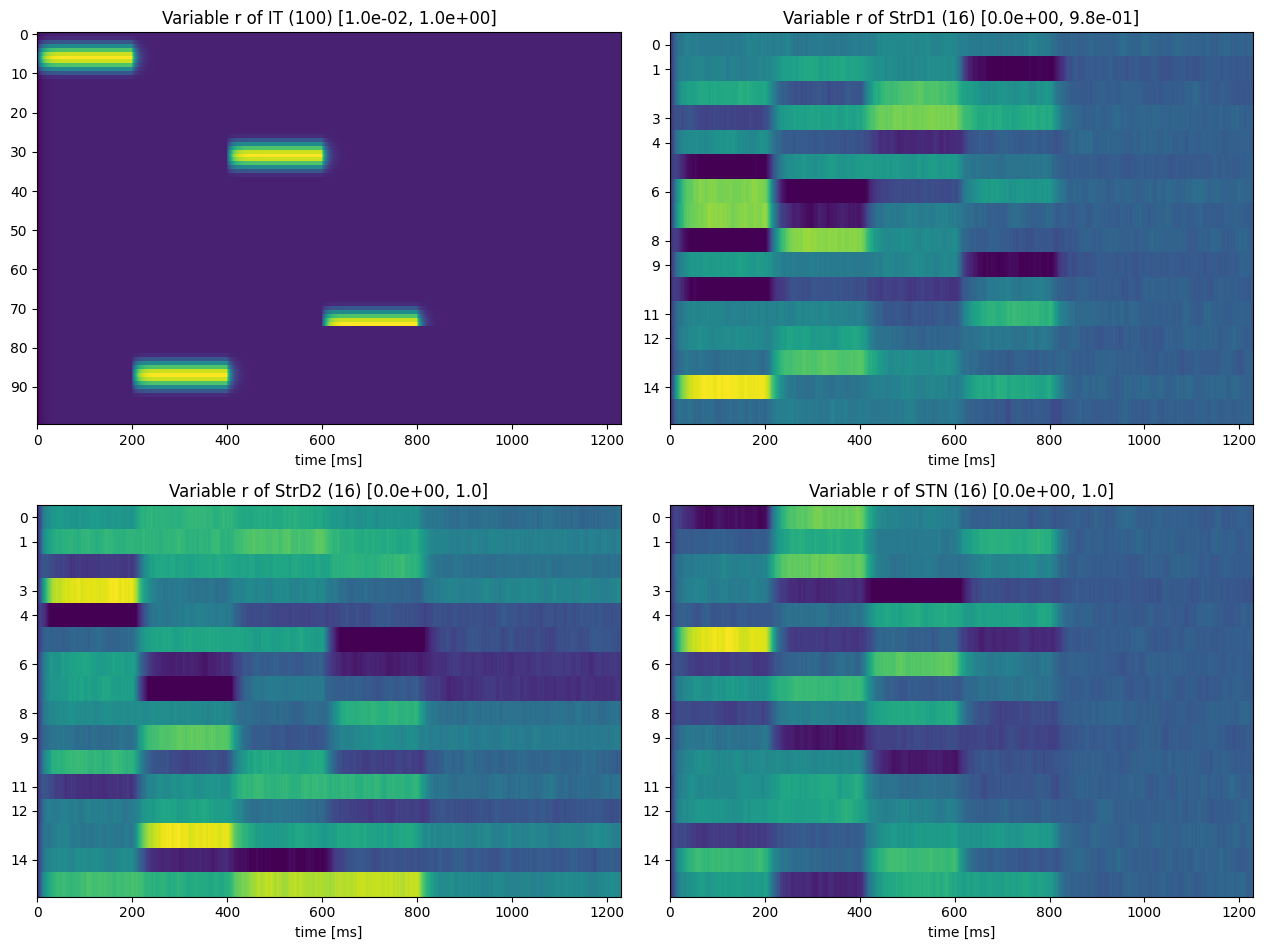

In [23]:
for chunk in range(len(recordings1)):
        ### using plot_recordings which plots the recordings of one chunk
        PlotRecordings(
            figname=f"monitor_recordings_1_chunk{chunk}.png",
            recordings=recordings1,
            #recording_times=recording_times1,
            recording_times=recording_times1,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["IT", "StrD1","StrD2","STN"],
                "variable": ["r", "r", "r", "r"],
                "format": ["matrix", "matrix", "matrix","matrix"],
            },
            chunk=chunk,

        )
        plt.savefig(f"pw3{chunk}.png")
        print(chunk)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
for chunk in range(len(recordings1)):


   PlotRecordings(
            figname=f"mon_recordings_1_chunk{chunk}.png",
            recordings=recordings1,
            recording_times=recording_times1,
            shape=(1,3),
            plan={
                "position": [1,2,3],
                "compartment": ["SNr","VA-PFC", "PM"],
                "variable": ["r", "r", "r"],
                "format": ["matrix", "matrix", "matrix"],
            },
            chunk=chunk,


   )
   plt.savefig(f"pw3{chunk}.png")
   print(chunk)

NameError: name 'recordings1' is not defined

Generate fig monitor_recordings_1_chunk0.png... Done

Generate fig monitor_recordings_1_chunk1.png... Done

Generate fig monitor_recordings_1_chunk2.png... 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

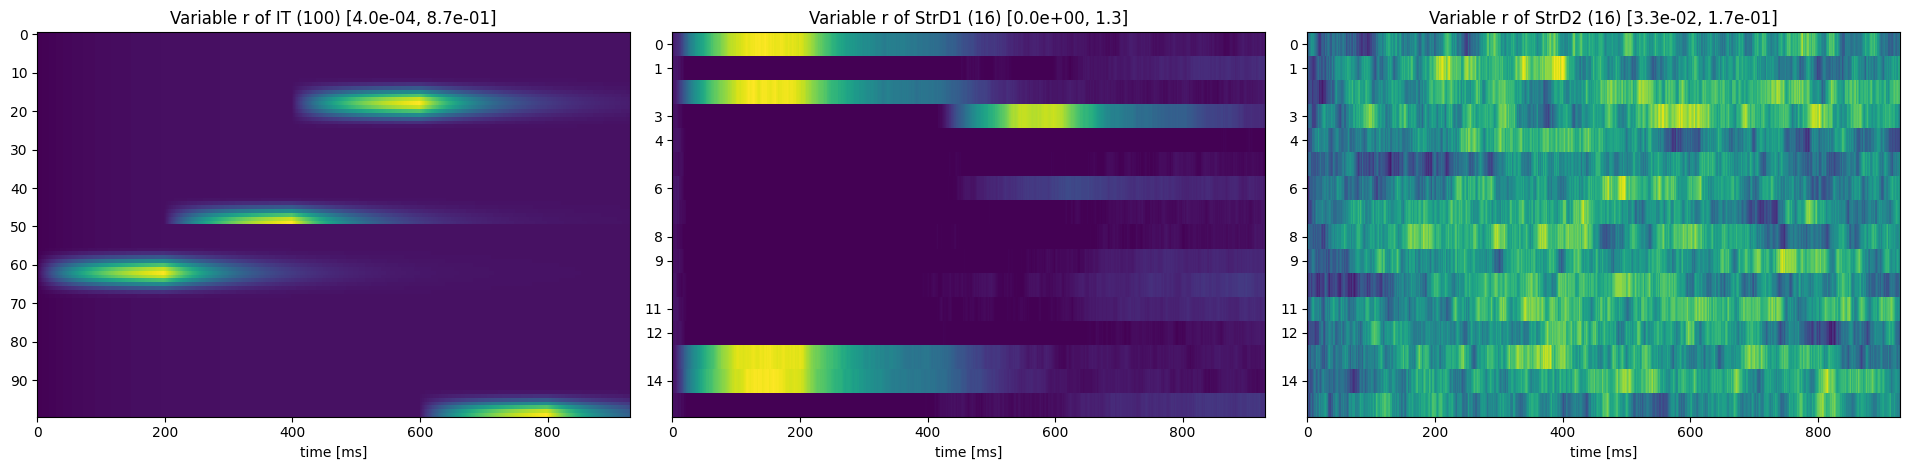

In [ ]:
for chunk in range(len(recordings1)):
        ### using plot_recordings which plots the recordings of one chunk
        PlotRecordings(
            figname=f"monitor_recordings_1_chunk{chunk}.png",
            recordings=recordings1,
            recording_times=recording_times1,
            shape=(1,3),
            plan={
                "position": [1, 2, 3],
                "compartment": ["IT", "StrD1", "StrD2"],
                "variable": ["r", "r", "r"],
                "format": ["matrix", "matrix", "matrix"],
            },

            chunk=chunk,
                       )

        plt.savefig(f"pw3{chunk}.png")

In [ ]:
print(len(recordings1))

1


In [ ]:
for idx in range(10):

    PlotRecordings(
    figname=f"test_plots/new_structure1/fish_presentation_{idx}.png",
    recordings=recordings,
    recording_times=recording_times1,
    chunk=0,
    shape=(1,2),
    plan=plot_list,


    #.time_lims(chunk=0, period=idx),
    dpi=300)

TypeError: Parameter plan of function <function PlotRecordings.__init__ at 0x7c1b2e399c60> should be <class 'dict'>

In [ ]:

for x in recordings1:
    plot_list = [f"{idx + 1};{pop};r;matrix" for idx, pop in enumerate(populations)]
    print(plot_list)
    print(populations)
    #print(x)
    print(x['IT;r'])
    dno=x['VA-PFC;r']
    dls=[f"{p};r" for p in populations]

   # print(dls)
    for s in populations:
        d=x[f"{s};r"]
        import numpy as np
        np.savetxt('data{}.csv'.format(s),d, delimiter=',')


['1;IT;r;matrix', '2;Reward_Layer;r;matrix', '3;PFC;r;matrix', '4;SNc;r;matrix', '5;StrD1;r;matrix', '6;StrD2;r;matrix', '7;StrThal-PFC;r;matrix', '8;SNr-GPi;r;matrix', '9;STN;r;matrix', '10;GPe;r;matrix', '11;VA-PFC;r;matrix', '12;PM;r;matrix']
['IT', 'Reward_Layer', 'PFC', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'SNr-GPi', 'STN', 'GPe', 'VA-PFC', 'PM']
[[0.00792658 0.00792658 0.00792658 ... 0.00792658 0.00792658 0.00792658]
 [0.0150605  0.0150605  0.0150605  ... 0.0150605  0.0150605  0.0150605 ]
 [0.02148102 0.02148102 0.02148102 ... 0.02148102 0.02148102 0.02148102]
 ...
 [0.07926577 0.07926577 0.07926577 ... 0.07926577 0.07926577 0.07926577]
 [0.07926577 0.07926577 0.07926577 ... 0.07926577 0.07926577 0.07926577]
 [0.07926577 0.07926577 0.07926577 ... 0.07926577 0.07926577 0.07926577]]


[[0.03415123 0.04284778 0.03017577 ... 0.03614914 0.0496695  0.04065299]
 [0.05859396 0.05075289 0.05321801 ... 0.06247501 0.07239517 0.05485208]
 [0.05745808 0.06827003 0.0684737  ... 0.07458393 0.07571601 0.05722999]
 ...
 [0.08769255 0.07216318 0.11033798 ... 0.07992731 0.06939516 0.08221727]
 [0.08801996 0.07838962 0.10727092 ... 0.08261093 0.06699064 0.07919114]
 [0.09337417 0.07198419 0.10963913 ... 0.08718926 0.07362921 0.07026388]]


<Axes: >

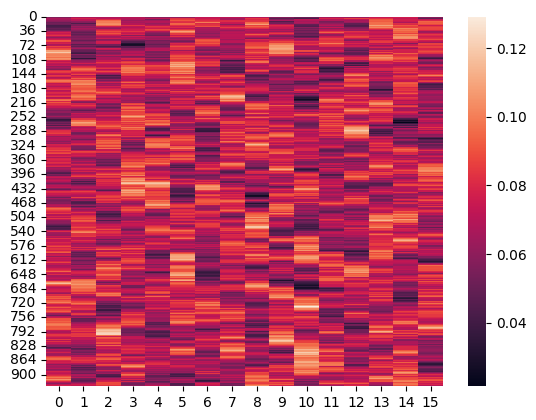

In [ ]:
print(x['StrD1;r'])
import seaborn as sns
sns.heatmap(x['StrD1;r'][0:930])

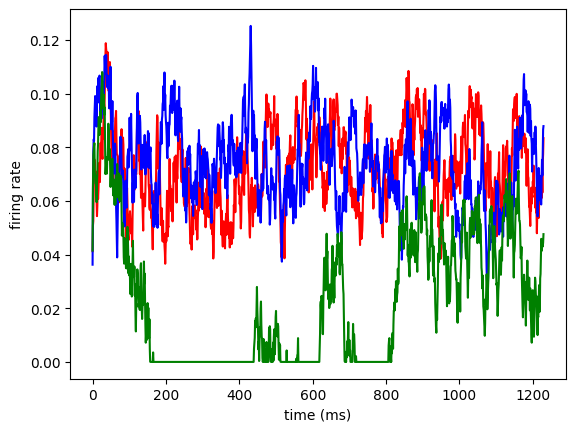

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x['StrD1;r'][0:1250][:,0],color='r')
plt.plot(x['STN;r'][0:1250][:,0],color='b')
plt.plot(x['StrD2;r'][0:1250][:,0],color='g')
plt.xlabel('time (ms)')
plt.ylabel('firing rate')
plt.label=('Hyperdirect Pathway')
plt.xlim=np.arange(14680,13450)

<Axes: >

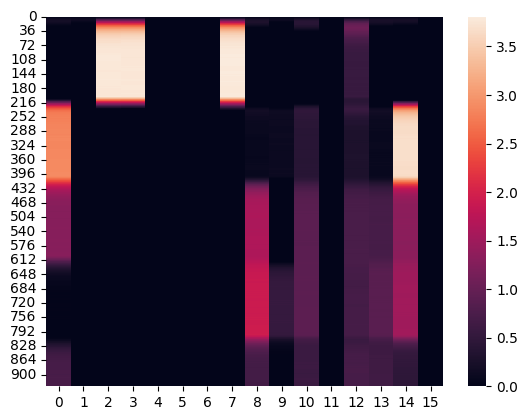

In [ ]:
import seaborn as sns

sns.heatmap(x['PFC;r'][0:930])

In [ ]:
import seaborn as sns

sns.heatmap(x['StrD1;r'][0:1060])

In [ ]:
import seaborn as sns

sns.heatmap(x['GPi-PFC;r'][0:1230])

In [ ]:
sns.heatmap(x['GPi;r'][0:1230])


In [ ]:
#print(x['GPe;r'][0:850][0][0])
z=[]
s=[]
for i in range(len(x['GPe;r'][0:850])):
  print(x['GPe;r'][0:i+1][i])

  z.append(x['GPe;r'][0:i+1][i][0])
  s.append(x['GPe;r'][0:i+1][i][1])
print(z)
print(x['GPe;r'][0:850:200])


sns.heatmap(x['GPe;r'][0:1060:230])


In [ ]:
print(x['VA-PFC;r'])
import seaborn as sns
sns.heatmap(x['VA-PFC;r'][0:1060])



In [ ]:
plt.subplot(4, 1, 1)
sns.heatmap(x['IT;r'][0:1230])
plt.subplot(4, 1, 2)
sns.heatmap(x['StrD1;r'][0:1230])
plt.subplot(4, 1, 3)
sns.heatmap(x['StrD2;r'][0:1230])
plt.subplot(4, 1, 4)
sns.heatmap(x['STN;r'][0:1230])

plt.show()

In [ ]:
plt.subplot(4, 1, 1)
sns.heatmap(x['GPi;r'][0:1230])
plt.subplot(4, 1, 2)
sns.heatmap(x['VA-PFC;r'][0:1230])
plt.subplot(4, 1, 3)
sns.heatmap(x['PM;r'][0:1230])
plt.subplot(4, 1, 4)
sns.heatmap(x['GPe;r'][0:860:230])

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')
ax = ax.flatten()

# Default norm:
pcm = ax[0].pcolormesh(x['IT;r'][0:1230],rasterized=True, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[0], orientation='vertical')
ax[0].set_title('IT')
ax[0].set_xlabel('features')
ax[0].set_ylabel('time steps')

# Even bounds give a contour-like effect:
bounds = np.linspace(-1.5, 1.5, 7)
pcm = ax[1].pcolormesh(x['StrD1;r'][0:1230], rasterized=True, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[1], extend='both',  shrink=0.6, orientation='vertical')
ax[1].set_title('StrD1')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('neurons')
bounds = np.linspace(-1.5, 1.5, 7)
pcm = ax[2].pcolormesh(x['StrD2;r'][0:1230], rasterized=True,  cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[2], extend='both', shrink=0.6, orientation='vertical')
ax[2].set_title('StrD2')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('neurons')
bounds = np.linspace(-1.5, 1.5, 7)
pcm = ax[3].pcolormesh(x['STN;r'][0:1230], rasterized=True,  cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[3], extend='both', shrink=0.6, orientation='vertical')
ax[3].set_title('STN')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('neurons')

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')
ax = ax.flatten()

# Default norm:
pcm = ax[0].pcolormesh(x['GPi;r'][0:1230],rasterized=True, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[0], orientation='vertical')
ax[0].set_title('GPi-PFC')
ax[0].set_xlabel('features')
ax[0].set_ylabel('time steps')

# Even bounds give a contour-like effect:
bounds = np.linspace(-1.5, 1.5, 7)
pcm = ax[1].pcolormesh(x['GPe;r'][0:1230], rasterized=True, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[1], extend='both',  shrink=0.6, orientation='vertical')
ax[1].set_title('GPe;r')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('neurons')
bounds = np.linspace(-1.5, 1.5, 7)
pcm = ax[2].pcolormesh(x['VA-PFC;r'][0:1230], rasterized=True,  cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[2], extend='both', shrink=0.6, orientation='vertical')
ax[2].set_title('VA-PFC')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('neurons')
bounds = np.linspace(-1.5, 1.5, 7)
pcm = ax[3].pcolormesh(x['PM;r'][0:1230], rasterized=True,  cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[3], extend='both', shrink=0.6, orientation='vertical')
ax[3].set_title('PM')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('neurons')

In [ ]:
import pandas as pd
import seaborn as sns
data_top =dno
print(data_top)
df = pd.read_csv('dataGPe.csv')
print(df[4350:5180])
x=df['1.494106053670226364e-01']
y=df['7.958343068463433201e-02']
sns.kdeplot(df)
#sns.heatmap(df)
g = sns.JointGrid(data=df[13450:14680], x="1.494106053670226364e-01", y="7.958343068463433201e-02", marginal_ticks=True)
#g.ax_joint.set(yscale="log")
cax = g.figure.add_axes([.15, .55, .02, .2])
g.plot_joint(sns.histplot, discrete=(True, False),cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [ ]:
plot_recordings(
    figname=f"test_plots/new_structure4/fish_presentation_{170}.png",
    recordings=recordings,
    recording_times=recording_times,
    chunk=0,
    shape=(2, 6),
    plan=plot_list,
    time_lim=recording_times.time_lims(chunk=0, period=idx),
    dpi=300)

In [ ]:
for x in recordings:
  print(x)
lst=mon.timings['StrD1']
lst1=lst['start']
resul = [int(item) for item in lst1]
#print(resul)
#plt.plot(x['StrD1;r'][0:1230][:,0],color='b')


index = 0            # Python's indexing starts at zero
num = []
dum = []
for index, item in enumerate(resul, start=0):   # default is zero
  #  print(index, item)
   # print(resul[index])
    #i=resul[index]
    print(index)
    num.append(index)
    dum.append(index)
    num.append(item)
    rs=resul[index-1]
    rz=resul[index]
    print(rs,"hast:",rz)
    fig, ax=plt.subplots()
    ax=ax
    ax.plot(x['StrD1;r'][rs:rz][:,0],label='Direct Pathway')
    ax.plot(x['StrD2;r'][rs:rz][:,0],label='Indirect Pathway')
    ax.plot(x['STN;r'][rs:rz][:,0],label='Hyperdirect Pathway')
    cmap = plt.get_cmap('plasma')
    ax.set(title='Interaction of the Pathways',xlabel='time(ms)',ylabel='firing rate')
    ax.legend()
    plt.savefig(f"interact_{index}.png")


In [ ]:
for idx, item in enumerate(num) :
    plt.plot(x['StrD1;r'][idx:idx+1],label='Direct Pathway')
    plt.plot(x['StrD2;r'][idx:idx+1],label='Indirect Pathway')
    plt.plot(x['STN;r'][idx:idx+1],label='Hyperdirect Pathway')
    cmap = plt.get_cmap('plasma')
    plt.title('Interaction of the Pathways')
    plt.xlabel('time(ms)')
    plt.xlabel('firing rate')
    plt.legend()

    plt.savefig(f"pw3{idx}.png")
    plt.close()

In [ ]:
plt.plot(x['StrD1;r'][4350:5180][:,0],label='Direct Pathway')
plt.plot(x['StrD2;r'][4350:5180][:,0],label='Indirect Pathway')
plt.plot(x['STN;r'][4350:5180][:,0],label='Hyperdirect Pathway')
cmap = plt.get_cmap('plasma')
plt.title('Interaction of the Pathways')
plt.xlabel('time(ms)')
plt.xlabel('firing rate')
plt.legend()

In [ ]:
import os
os.getcwd( )
import pandas as pd
df=pd.read_csv('dataVA-PFC.csv')
df2=df[4350:5180]
fig, ax=plt.subplots()
import seaborn as sns
sns.heatmap(df2)
ax.xlabel='Primary Motor Cortex'

In [ ]:
plot_recordings(
    figname=f"test_plots/new_structure4/fish_presentation_{190}.png",
    recordings=recordings,
    recording_times=recording_times,
    chunk=0,
    shape=(3, 4),
    plan=plot_list,
    time_lim=recording_times.time_lims(chunk=0, period=1),
    dpi=300)

In [ ]:
import seaborn as sns
import pandas as pd

dd=pd.read_csv('dataGPi-PFC.csv')
print(dd.head)
import seaborn as sns
import pandas as pd

dd=pd.read_csv('dataGPe.csv')
print(dd.head)

In [ ]:
sns.kdeplot(dd[4350:5180])
x=dd['1.494106053670226364e-01']
y=dd['7.958343068463433201e-02']
g = sns.JointGrid(data=dd[4350:5180], x="1.494106053670226364e-01", y="7.958343068463433201e-02", marginal_ticks=True)
cax = g.figure.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")
sns.set_theme(style="white")

In [ ]:
dirpa=pd.read_csv('dataPFC_MTL.csv')
dirpa=pd.DataFrame(dirpa)
dirpa.describe
# calculate the correlation matrix on the numeric columns
corr = dirpa.select_dtypes('number').corr()
# plot the heatmap
sns.heatmap(corr)




In [ ]:
dird1=pd.read_csv('dataStrThal-PFC.csv')
gpi=pd.read_csv('dataGPi-PFC.csv')
pm=pd.read_csv('dataPM.csv')
indir=pd.read_csv('dataPFC_MTL.csv')
sns.heatmap(indir.T,cmap='hot')

{'DF': -1.0, 'TF': 0.0, 'VF': 1.0, 'MA': 1.0}